### Install necessary libraries

In [8]:
pip install osmnx geopandas pydeck seaborn

Note: you may need to restart the kernel to use updated packages.


### Visualizing buildings from benguerir

In [9]:
import osmnx as ox
import geopandas as gpd
import pydeck as pdk
import numpy as np
import pandas as pd


city_name = "Casablanca, Morocco"

gdf = ox.features_from_place(city_name, tags={"building": True})
gdf = gdf[gdf.geometry.type == "Polygon"]


gdf["CO2_Usage"] = np.random.uniform(50, 500, len(gdf))  # CO₂ usage in kg/month
gdf["Water_Usage"] = np.random.uniform(1000, 10000, len(gdf))  # Water usage in liters/month
gdf["Energy_Consumption"] = np.random.uniform(500, 5000, len(gdf))  # Energy consumption in kWh/month

# Assign random heights (since OSM may not have height info)
gdf["height"] = np.random.uniform(10, 100, len(gdf)) 
gdf["footprint"] = gdf["geometry"].apply(lambda geom: [[list(coord) for coord in geom.exterior.coords]])

def get_color(co2_usage):
    if co2_usage > 400:
        return [255, 0, 0, 200]  # High CO₂ (Red)
    elif co2_usage > 200:
        return [255, 165, 0, 200]  # Medium CO₂ (Orange)
    else:
        return [0, 255, 0, 200]  # Low CO₂ (Green)

gdf["color"] = gdf["CO2_Usage"].apply(get_color)

# Convert to DataFrame for pydeck
data = gdf[["footprint", "height", "CO2_Usage", "Water_Usage", "Energy_Consumption", "color"]].reset_index()


building_layer = pdk.Layer(
    "PolygonLayer",
    data,
    get_polygon="footprint",
    get_elevation="height",
    elevation_scale=1,
    get_fill_color="color",  # Color based on CO₂
    extruded=True,
    pickable=True,
    auto_highlight=True,
)

view_state = pdk.ViewState(
    latitude=gdf.geometry.centroid.y.mean(),
    longitude=gdf.geometry.centroid.x.mean(),
    zoom=15,
    pitch=50,
)

deck = pdk.Deck(
    layers=[building_layer],
    initial_view_state=view_state,
    tooltip={"text": "Height: {height}m\nCO₂: {CO2_Usage}kg\nWater: {Water_Usage}L\nEnergy: {Energy_Consumption}kWh"}
)

deck.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_13512\2644202129.py:49: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude=gdf.geometry.centroid.y.mean(),
C:\Users\USER\AppData\Local\Temp\ipykernel_13512\2644202129.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude=gdf.geometry.centroid.x.mean(),


DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…

### Given real data we can use the distribution to simulate other data 

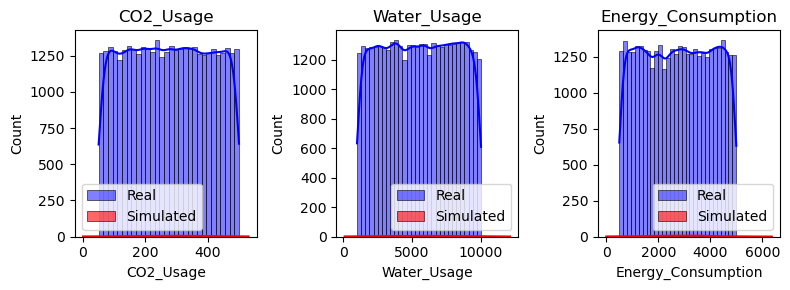

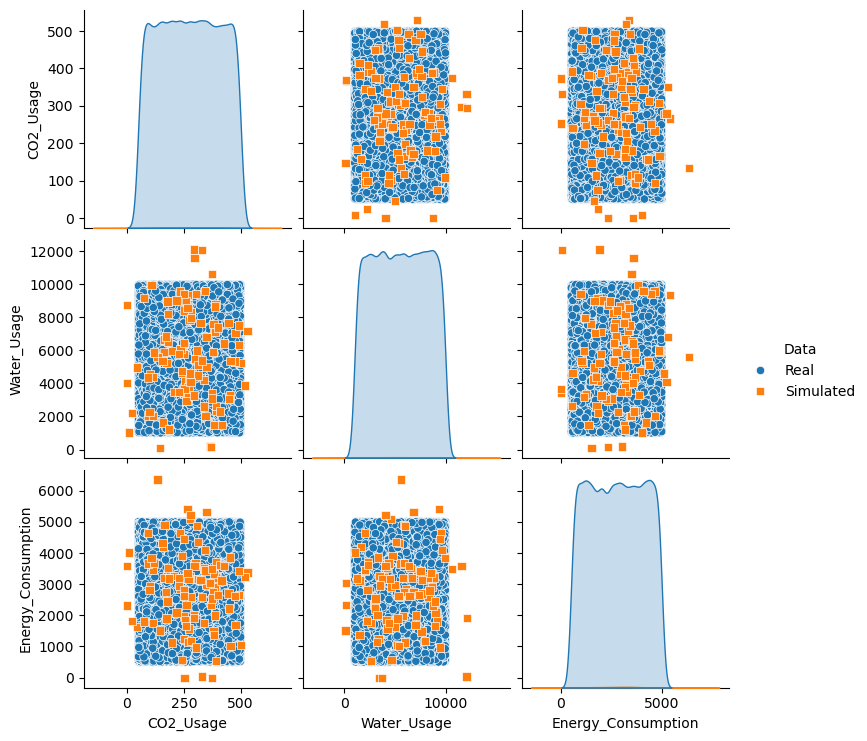

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load real data from your dataset
real_data = gdf[["CO2_Usage", "Water_Usage", "Energy_Consumption"]]

# Compute mean vector and covariance matrix dynamically
mean_vector = real_data.mean().values
cov_matrix = real_data.cov().values


# Generate synthetic data
num_samples = 100
simulated_data = np.random.multivariate_normal(mean_vector, cov_matrix, num_samples)

# Convert to DataFrame
df_simulated = pd.DataFrame(simulated_data, columns=["CO2_Usage", "Water_Usage", "Energy_Consumption"])

# Ensure no negative values
df_simulated = df_simulated.clip(lower=0)

# Plot histograms of real vs. simulated data
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

for i, col in enumerate(["CO2_Usage", "Water_Usage", "Energy_Consumption"]):
    sns.histplot(real_data[col], bins=30, kde=True, color='blue', label="Real", ax=axes[i])
    sns.histplot(df_simulated[col], bins=30, kde=True, color='red', label="Simulated", ax=axes[i], alpha=0.6)
    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Scatter plot to see relationships
sns.pairplot(pd.concat([real_data.assign(Data="Real"), df_simulated.assign(Data="Simulated")]), 
             hue="Data", diag_kind="kde", markers=["o", "s"])
plt.show()


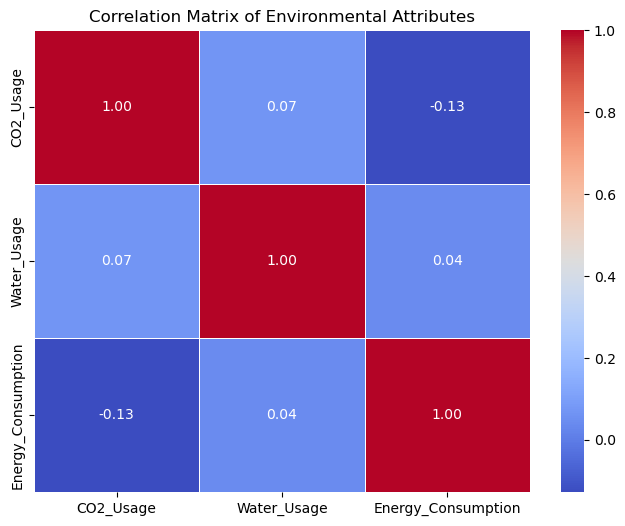

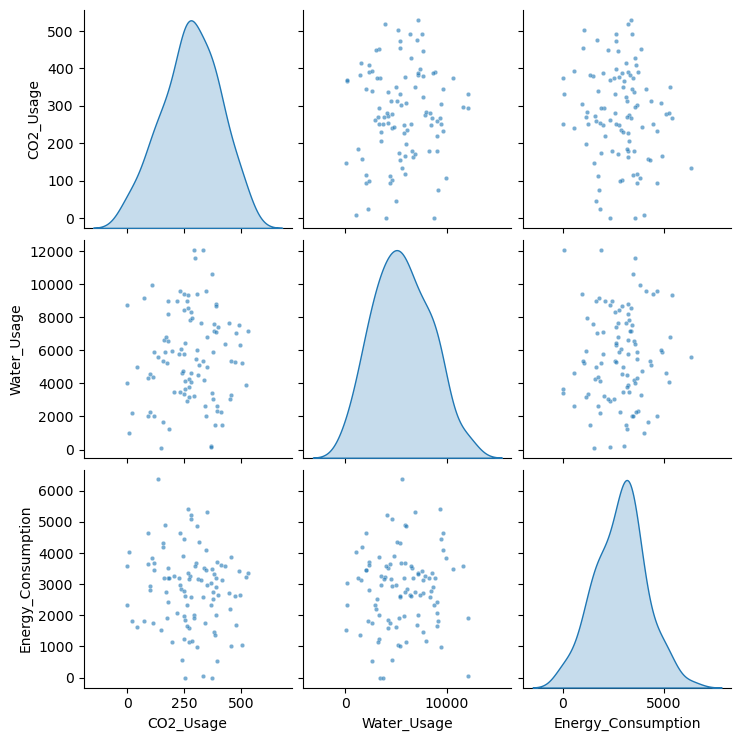

In [11]:
# Ensure all values are finite and numeric
df_simulated_clean = df_simulated.select_dtypes(include=[np.number]).dropna()

# Compute the correlation matrix
correlation_matrix_clean = df_simulated_clean.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_clean, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Environmental Attributes")
plt.show()

# Pairplot for visualizing distributions and relationships
sns.pairplot(df_simulated_clean, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 10})
plt.show()

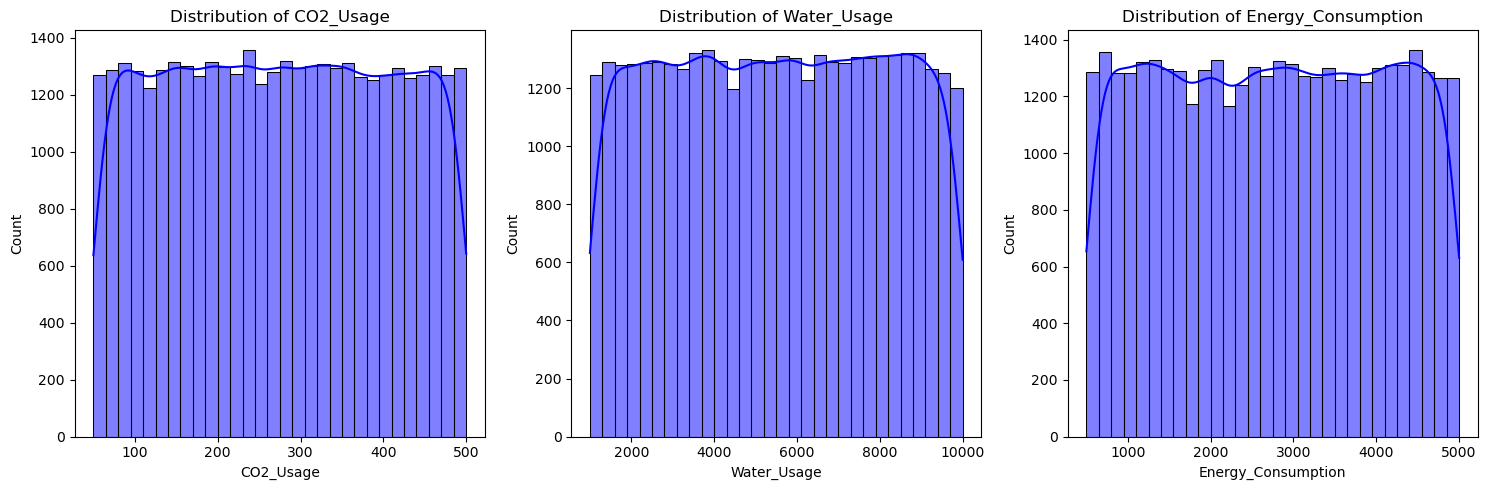

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms with KDE
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(["CO2_Usage", "Water_Usage", "Energy_Consumption"]):
    sns.histplot(real_data[col], bins=30, kde=True, ax=axes[i], color="blue")
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


### Some other plots

In [ ]:
import scipy.stats as stats

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(["CO2_Usage", "Water_Usage", "Energy_Consumption"]):
    stats.probplot(real_data[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"QQ-Plot of {col}")

plt.tight_layout()
plt.show()


### Or if we know the correlations between the 3 elements

    CO2_Usage  Water_Usage  Energy_Consumption
0  251.854840  4857.675129         2416.424033
1  200.950011  4543.546550         2266.578665
2  211.396864  4459.477748         2411.380263
3  269.272372  4861.089180         2357.854962
4  302.551377  5045.146999         2172.223195


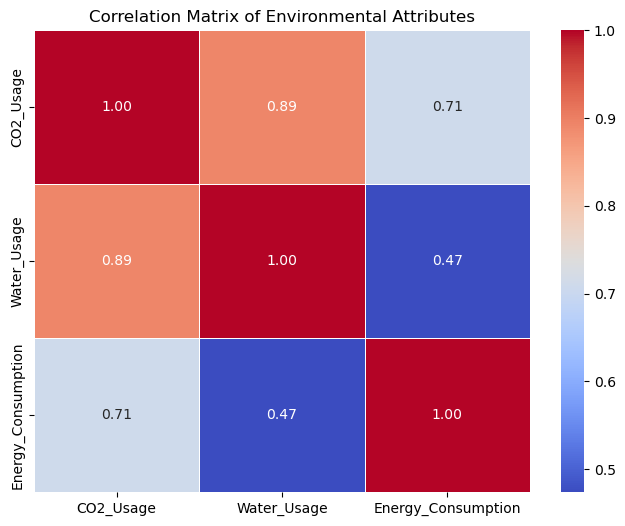

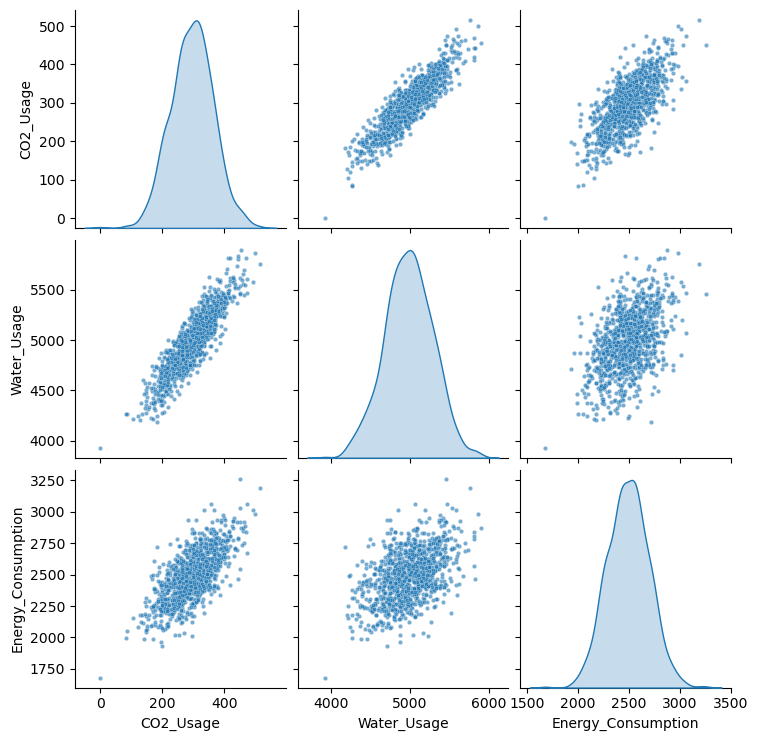

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Define mean values for each feature (CO₂ Usage, Water Usage, Energy Consumption)
mean_vector = np.array([300, 5000, 2500])  

# Define covariance matrix (assumed correlations)
cov_matrix = np.array([
    [5000,  20000,  10000],  # Variance & covariance between CO₂, Water, and Energy
    [20000, 100000, 30000], 
    [10000, 30000, 40000]
])

# Generate 1000 random samples
num_samples = 1000
simulated_data = np.random.multivariate_normal(mean_vector, cov_matrix, num_samples)

# Convert to DataFrame
df_simulated = pd.DataFrame(simulated_data, columns=["CO2_Usage", "Water_Usage", "Energy_Consumption"])

# Ensure values remain positive
df_simulated = df_simulated.clip(lower=0)

# Display first few rows
print(df_simulated.head())

# Compute the correlation matrix
correlation_matrix = df_simulated.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Environmental Attributes")
plt.show()

# Pairplot for visualizing distributions and relationships
sns.pairplot(df_simulated, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 10})
plt.show()
